In [ ]:
from google.colab import files
import io
import pandas as pd

mini_train = files.upload()

filename = next(iter(mini_train))
file_content = mini_train[filename]
mini_train_df = pd.read_csv(io.BytesIO(file_content))
mini_train_sorted = mini_train_df.sort_values(by=['player_id', 'Year'])
mini_train_sorted['market_value_difference'] = mini_train_sorted.groupby('player_id')['market_value_in_eur'].diff()

mini_train_sorted['market_value_difference'] = mini_train_sorted['market_value_difference'].fillna(0)

mini_train_sorted['target'] = pd.cut(
    mini_train_sorted['market_value_difference'],
    bins=[-float('inf'), -0.1, 0.1, float('inf')],
    labels=['decrease', 'stay', 'increase']
)

missing_data = mini_train_sorted.isnull().sum()

print(mini_train_sorted['target'].value_counts())
print(missing_data[missing_data > 0])


Saving pre_model_data.csv to pre_model_data (3).csv
target
decrease    5249
increase    3543
stay        2795
Name: count, dtype: int64
country_of_birth          479
country_of_citizenship    424
city_of_birth              55
foot                        6
height_in_cm                6
dtype: int64


In [ ]:
mini_train_sorted.head()

,player_id,Year,matches_appearances,yellow_permatch,red_permatch,goals_permatch,assists_permatch,min_permatch,name,country_of_birth,...,major_league,Age,market_value_in_eur,value_increase,matches,club_changed,type_ratio,ever_captain,market_value_difference,target
7488,3333,2016,39,0.153846,0.0,0.230769,0.333333,85.487179,James Milner,England,...,1,30,15000000,0,40,0,19.000000,1,0.0,stay
7489,3333,2017,42,0.119048,0.0,0.047619,0.190476,68.238095,James Milner,England,...,1,31,12000000,0,49,0,1.450000,1,-3000000.0,decrease
7490,3333,2018,45,0.111111,0.0,0.133333,0.155556,67.844444,James Milner,England,...,1,32,15000000,1,48,0,2.200000,1,3000000.0,increase
7491,3333,2019,47,0.234043,0.0,0.085106,0.148936,50.829787,James Milner,England,...,1,33,12000000,0,52,0,0.857143,1,-3000000.0,decrease
7492,3333,2020,25,0.240000,0.0,0.000000,0.040000,44.600000,James Milner,England,...,1,34,5000000,0,29,0,0.705882,1,-7000000.0,decrease


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

categorical_columns = ['country_of_birth', 'country_of_citizenship', 'city_of_birth']
mini_train_sorted[categorical_columns] = mini_train_sorted[categorical_columns].fillna('Unknown')

encoder = LabelEncoder()
for col in categorical_columns + ['name', 'position', 'foot']:
    mini_train_sorted[col] = encoder.fit_transform(mini_train_sorted[col])

X = mini_train_sorted.drop(['target', 'market_value_in_eur', 'market_value_difference'], axis=1)
y = mini_train_sorted['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train.head()


,player_id,Year,matches_appearances,yellow_permatch,red_permatch,goals_permatch,assists_permatch,min_permatch,name,country_of_birth,...,height_in_cm,mat,win_percentage,major_league,Age,value_increase,matches,club_changed,type_ratio,ever_captain
9885,-1.075036,-0.659268,0.021797,1.382052,-0.235211,0.056422,-0.488907,0.508418,1.362777,1.365564,...,-0.195128,0.021797,0.377608,-1.274769,0.450672,1.508398,-0.019025,-0.564683,-0.206679,1.870699
6527,1.166907,1.538846,-0.398418,-0.456277,-0.235211,-0.740819,0.078143,-0.539440,-1.656342,-0.748554,...,-0.348489,-0.398418,1.255380,0.784456,-0.286972,-0.662955,-0.880912,-0.564683,-0.593219,-0.534560
3851,0.295073,-1.098891,1.282442,-0.843747,-0.235211,1.650904,0.624941,-0.456033,-1.441534,0.686026,...,0.418316,1.282442,-0.115019,0.784456,-1.270497,1.508398,1.877127,1.770904,-0.577113,-0.534560
890,-0.430726,-0.659268,1.198399,-1.051657,-0.235211,-0.740819,-0.878754,1.117163,0.284015,0.421761,...,1.645205,1.198399,0.512179,-1.274769,-0.041091,1.508398,0.929051,-0.564683,3.272175,-0.534560
519,-0.548801,-0.219645,-0.062246,-0.237207,-0.235211,-0.464851,-0.069072,0.256667,-1.120502,-0.522041,...,-1.728739,-0.062246,-0.046809,0.784456,0.204790,-0.662955,1.015240,1.770904,-0.593219,-0.534560


# Neural Networks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # for three classes: increase, decrease, stay
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))


In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
232/232 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.7167 - val_loss: nan - val_accuracy: 0.4547
Epoch 2/50
232/232 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 3/50
232/232 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 4/50
232/232 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 5/50
232/232 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 6/50
232/232 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 7/50
232/232 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.4558 - val_loss: nan - val_accuracy: 0.4547
Epoch 8/50
232/232 [============================

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)


In [ ]:
from tensorflow.keras.optimizers import Adam
import numpy as np


optimizer = Adam(learning_rate=0.001)  # Can  adjust learning rate here, starting with a lower value

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ensure no NaN values in data
assert not np.isnan(X_train).any(), "NaN values in X_train"
assert not np.isnan(X_test).any(), "NaN values in X_test"
assert not np.isnan(y_train_encoded).any(), "NaN values in y_train_encoded"
assert not np.isnan(y_test_encoded).any(), "NaN values in y_test_encoded"

# Re-run
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#trying fur tabular data
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Adjusted input shape
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  #  increase, decrease, stay
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.8240 - accuracy: 0.6328 - val_loss: 0.3872 - val_accuracy: 0.8589
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4142 - accuracy: 0.8320 - val_loss: 0.3252 - val_accuracy: 0.8693
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3585 - accuracy: 0.8506 - val_loss: 0.3202 - val_accuracy: 0.8719
Epoch 4/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3361 - accuracy: 0.8636 - val_loss: 0.3070 - val_accuracy: 0.8766
Epoch 5/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3221 - accuracy: 0.8686 - val_loss: 0.3049 - val_accuracy: 0.8753
Epoch 6/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3170 - accuracy: 0.8724 - val_loss: 0.3008 - val_accuracy: 0.8766
Epoch 7/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.8742 - val_loss: 0.2960 - val_accuracy: 0.8796
Epoch 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1664      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6019 (23.51 KB)
Trainable params: 6019 (23.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Stopping early to prevent overfitting

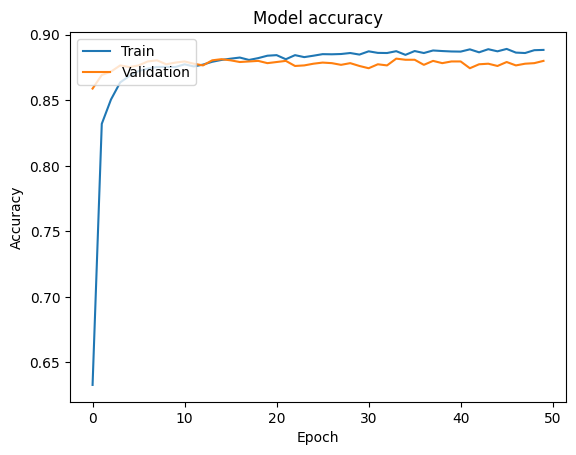

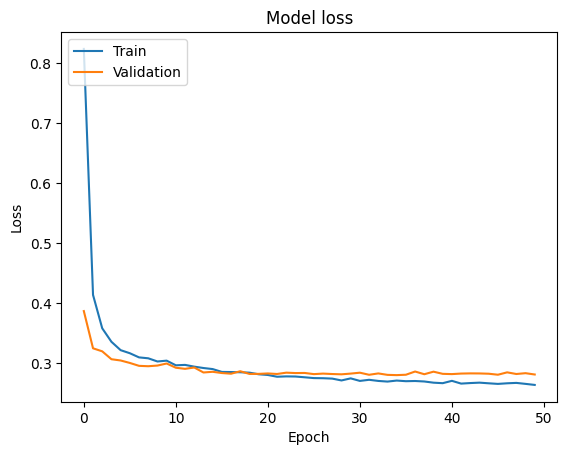

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


37/37 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3037
Test Loss: nan
Test Accuracy: 0.30371010303497314


In [ ]:
print("NaNs in X_test:", X_test.isnull().sum().sum())
print("Infs in X_test:", np.isinf(X_test).sum().sum())
print("NaNs in y_test_encoded:", np.isnan(y_test_encoded).sum())
print("Infs in y_test_encoded:", np.isinf(y_test_encoded).sum())


NaNs in X_test: 1
Infs in X_test: 0
NaNs in y_test_encoded: 0
Infs in y_test_encoded: 0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 3)).


In [ ]:
print("Unique labels:", np.unique(y_train_encoded))
print("Shape of labels:", y_train_encoded.shape)


Unique labels: [0. 1.]
Shape of labels: (8133, 3)


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 2) are incompatible


In [ ]:
print("Unique labels:", np.unique(y_train_encoded))


Unique labels: [0. 1.]


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train_encoded, num_classes=3)
y_test_encoded = to_categorical(y_test_encoded, num_classes=3)


In [ ]:
# Making predictions
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test_encoded.argmax(axis=1)

# Calculate and print metrics, confusion matrix, etc.
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, predicted_classes))
print(confusion_matrix(true_classes, predicted_classes))


37/37 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multiclass targets

In [ ]:
pip install tensorflow scikit-learn pandas


In [ ]:
from google.colab import files
data = files.upload()

Saving binary_convert.csv to binary_convert.csv


In [ ]:
import pandas as pd
from google.colab import files

uploaded_files = files.upload()


filename = next(iter(uploaded_files))
data = pd.read_csv(filename)

Saving binary_convert.csv to binary_convert.csv
   ever_captain  y2016  y2017  y2018  y2019  y2020  y2021  y2022  y2023  \
0             1      1      0      0      0      0      0      0      0   
1             1      0      1      0      0      0      0      0      0   
2             1      0      0      1      0      0      0      0      0   
3             0      0      0      0      1      0      0      0      0   
4             0      0      0      0      0      1      0      0      0   

   mapprear  ...  midfield  rfoot  heightbinary  highwin  old  expensiveguy  \
0         1  ...         1      0             1        1    0             1   
1         1  ...         1      0             1        0    0             1   
2         1  ...         1      0             1        0    0             1   
3         0  ...         1      0             1        0    0             1   
4         0  ...         1      0             1        1    0             1   

   lineuptime  major_leagu

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


X = data.drop(columns=['value_increase'])
y = data['value_increase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define  neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train  model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/50
232/232 [==============================] - 4s 6ms/step - loss: 0.5834 - accuracy: 0.6982 - val_loss: 0.4643 - val_accuracy: 0.7755
Epoch 2/50
232/232 [==============================] - 1s 6ms/step - loss: 0.4938 - accuracy: 0.7515 - val_loss: 0.4401 - val_accuracy: 0.7814
Epoch 3/50
232/232 [==============================] - 2s 8ms/step - loss: 0.4741 - accuracy: 0.7670 - val_loss: 0.4382 - val_accuracy: 0.7798
Epoch 4/50
232/232 [==============================] - 2s 6ms/step - loss: 0.4577 - accuracy: 0.7691 - val_loss: 0.4350 - val_accuracy: 0.7820
Epoch 5/50
232/232 [==============================] - 2s 7ms/step - loss: 0.4560 - accuracy: 0.7759 - val_loss: 0.4312 - val_accuracy: 0.7868
Epoch 6/50
232/232 [==============================] - 1s 4ms/step - loss: 0.4520 - accuracy: 0.7721 - val_loss: 0.4295 - val_accuracy: 0.7863
Epoch 7/50
232/232 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.7757 - val_loss: 0.4278 - val_accuracy: 0.7852
Epoch 

Epoch 1/50
232/232 [==============================] - 7s 10ms/step - loss: 0.5771 - accuracy: 0.7006 - val_loss: 0.4542 - val_accuracy: 0.7793
Epoch 2/50
232/232 [==============================] - 1s 6ms/step - loss: 0.4919 - accuracy: 0.7524 - val_loss: 0.4345 - val_accuracy: 0.7928
Epoch 3/50
232/232 [==============================] - 1s 4ms/step - loss: 0.4707 - accuracy: 0.7655 - val_loss: 0.4306 - val_accuracy: 0.7960
Epoch 4/50
232/232 [==============================] - 1s 4ms/step - loss: 0.4581 - accuracy: 0.7686 - val_loss: 0.4323 - val_accuracy: 0.7944
Epoch 5/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4485 - accuracy: 0.7778 - val_loss: 0.4279 - val_accuracy: 0.7890
Epoch 6/50
232/232 [==============================] - 1s 2ms/step - loss: 0.4466 - accuracy: 0.7738 - val_loss: 0.4279 - val_accuracy: 0.7922
Epoch 7/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4407 - accuracy: 0.7791 - val_loss: 0.4240 - val_accuracy: 0.7949
Epoch

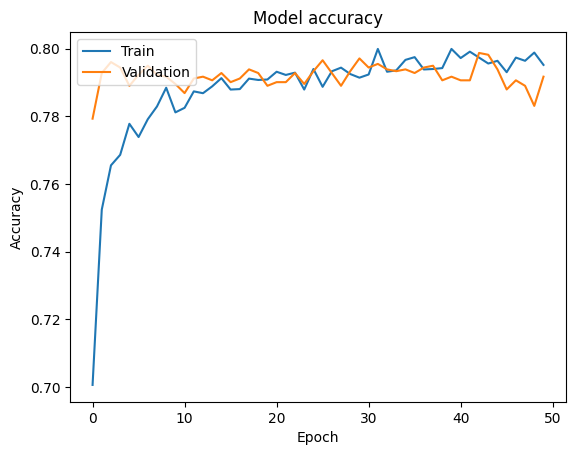

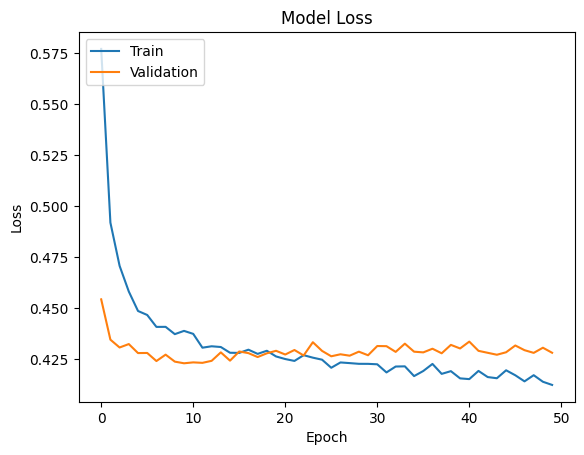

73/73 [==============================] - 0s 1ms/step - loss: 0.4625 - accuracy: 0.7704
Test Accuracy: 0.7704, Test Loss: 0.4625
73/73 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1590
           1       0.70      0.47      0.56       727

    accuracy                           0.77      2317
   macro avg       0.74      0.69      0.70      2317
weighted avg       0.76      0.77      0.76      2317



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


X = data.drop(columns=['value_increase'])
y = data['value_increase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# viz
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluatation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))


In [ ]:
from tensorflow.keras.optimizers import Adam

# Using a smaller learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Using LeakyReLU activation
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1]),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/50
232/232 [==============================] - 2s 3ms/step - loss: 0.5678 - accuracy: 0.7033 - val_loss: 0.4493 - val_accuracy: 0.7852
Epoch 2/50
232/232 [==============================] - 1s 2ms/step - loss: 0.4867 - accuracy: 0.7585 - val_loss: 0.4334 - val_accuracy: 0.7847
Epoch 3/50
232/232 [==============================] - 1s 2ms/step - loss: 0.4684 - accuracy: 0.7776 - val_loss: 0.4302 - val_accuracy: 0.7879
Epoch 4/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4578 - accuracy: 0.7730 - val_loss: 0.4299 - val_accuracy: 0.7874
Epoch 5/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4524 - accuracy: 0.7787 - val_loss: 0.4308 - val_accuracy: 0.7852
Epoch 6/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4470 - accuracy: 0.7765 - val_loss: 0.4293 - val_accuracy: 0.7863
Epoch 7/50
232/232 [==============================] - 1s 2ms/step - loss: 0.4423 - accuracy: 0.7842 - val_loss: 0.4275 - val_accuracy: 0.7917
Epoch 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

Epoch 1/50
232/232 [==============================] - 6s 10ms/step - loss: 0.5702 - accuracy: 0.7131 - val_loss: 0.4517 - val_accuracy: 0.7798
Epoch 2/50
232/232 [==============================] - 2s 8ms/step - loss: 0.4930 - accuracy: 0.7519 - val_loss: 0.4372 - val_accuracy: 0.7836
Epoch 3/50
232/232 [==============================] - 2s 11ms/step - loss: 0.4679 - accuracy: 0.7640 - val_loss: 0.4351 - val_accuracy: 0.7825
Epoch 4/50
232/232 [==============================] - 1s 6ms/step - loss: 0.4612 - accuracy: 0.7716 - val_loss: 0.4324 - val_accuracy: 0.7868
Epoch 5/50
232/232 [==============================] - 1s 5ms/step - loss: 0.4528 - accuracy: 0.7748 - val_loss: 0.4305 - val_accuracy: 0.7847
Epoch 6/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4455 - accuracy: 0.7784 - val_loss: 0.4283 - val_accuracy: 0.7906
Epoch 7/50
232/232 [==============================] - 1s 3ms/step - loss: 0.4486 - accuracy: 0.7749 - val_loss: 0.4282 - val_accuracy: 0.7852
Epoc

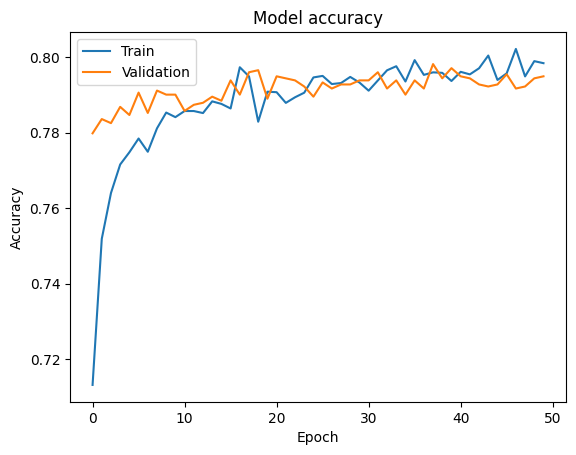

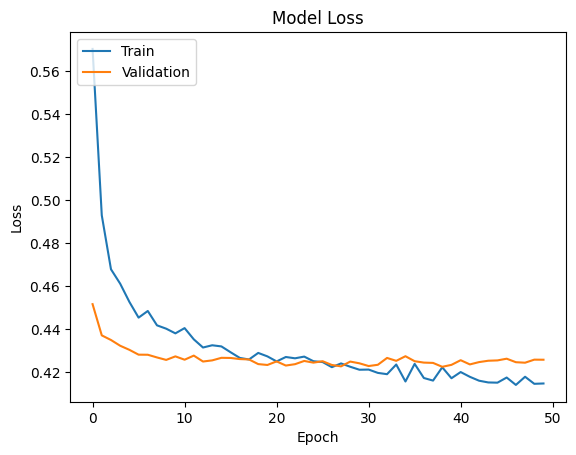

73/73 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.7734
Test Accuracy: 0.7734, Test Loss: 0.4658
73/73 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1590
           1       0.68      0.52      0.59       727

    accuracy                           0.77      2317
   macro avg       0.74      0.70      0.72      2317
weighted avg       0.76      0.77      0.76      2317



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming 'data' is already defined and loaded with appropriate data.

# Split the data into features and target
X = data.drop(columns=['value_increase'])
y = data['value_increase']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

# Generate predictions and evaluate further metrics
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/Models/valuation_prediction.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Models/valuation_prediction.keras')

new_data_scaled = scaler.transform(new_data)
predictions = model.predict(new_data_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Display predicted classes
print(predicted_classes)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Models/valuation_prediction.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Models/valuation_prediction.keras')


# continue


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from google.colab import files

uploaded_files = files.upload()

filename = next(iter(uploaded_files))
data = pd.read_csv(filename)


X = data.drop(columns=['value_increase'])
y = data['value_increase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Saving binary_convert.csv to binary_convert (3).csv
   ever_captain  y2016  y2017  y2018  y2019  y2020  y2021  y2022  y2023  \
0             1      1      0      0      0      0      0      0      0   
1             1      0      1      0      0      0      0      0      0   
2             1      0      0      1      0      0      0      0      0   
3             0      0      0      0      1      0      0      0      0   
4             0      0      0      0      0      1      0      0      0   

   mapprear  ...  midfield  rfoot  heightbinary  highwin  old  expensiveguy  \
0         1  ...         1      0             1        1    0             1   
1         1  ...         1      0             1        0    0             1   
2         1  ...         1      0             1        0    0             1   
3         0  ...         1      0             1        0    0             1   
4         0  ...         1      0             1        1    0             1   

   lineuptime  major_l

73/73 [==============================] - 1s 2ms/step


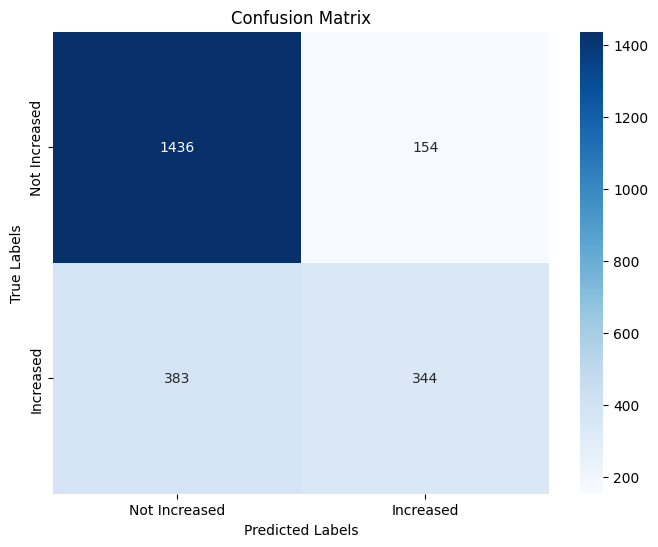

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'], yticklabels=['Not Increased', 'Increased'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


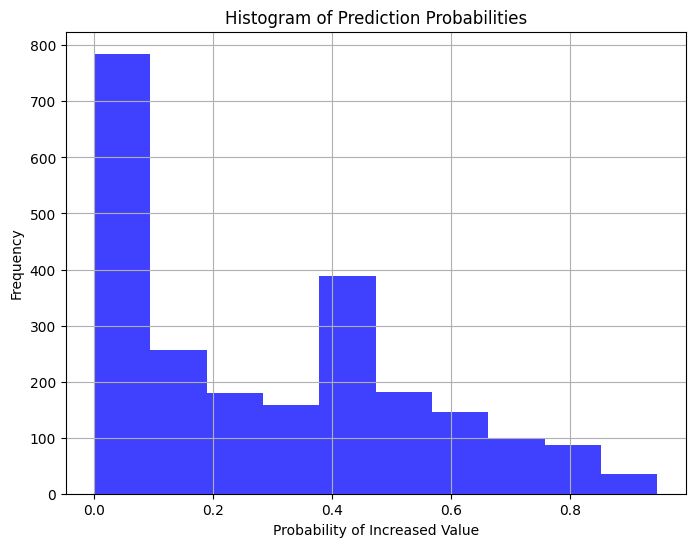

In [ ]:
# Assuming y_pred is a numpy array of prediction probabilities from model.predict()
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=10, alpha=0.75, color='blue')
plt.title('Histogram of Prediction Probabilities')
plt.xlabel('Probability of Increased Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


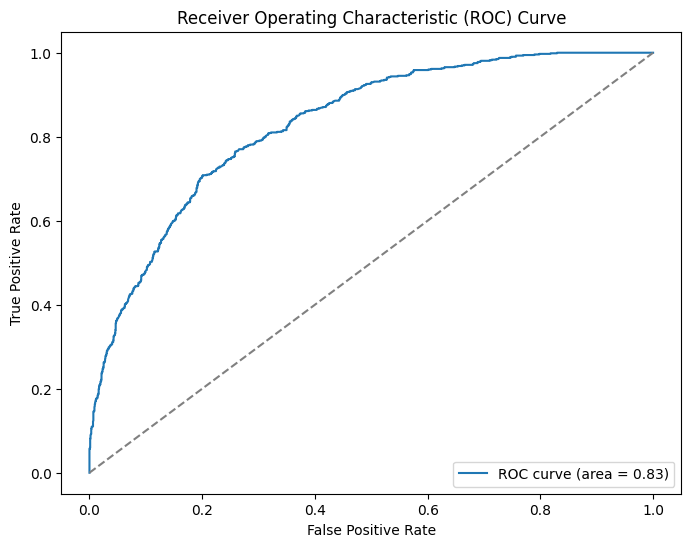

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
